# A tutorial on XRD-AutoAnalyzer

In this notebook, we will walk through each step required to construct and apply a simple XRD classification model. Examples are given for a composition space containing only LiF and MnO, each in the rocksalt structure, so that all calculations can be carried out quickly.

Note that this tutorial is merely designed to be a demonstration for how the approach works. For instructions on how to automatically perform all steps with a single line of code, please see https://github.com/njszym/XRD-AutoAnalyzer/blob/main/README.md.

## Model construction

We will first go through the necessary tasks to simulate spectra and train a model for a new composition space. This can be automated using construct_model.py, but here we will decompose this script into the individual steps.

### Step 1: Structure filtering

The first step for any new composition space is to organize available reference phases and filter them so that each a single entry is chosen to represent each unique phase.

A folder named All_CIFs is placed in the current directory. This folder contains several different entries for LiF and MnO. To filter these entries and create a set of unique reference phases, run the following code.


In [1]:
from autoXRD import tabulate_cifs
import os

cif_dir = 'All_CIFs' # Contains all CIFs, including duplicates
ref_dir = 'References' # Folder to place filtered CIFs

# Filter structure entries
tabulate_cifs.main(cif_dir, ref_dir)

print(os.listdir(ref_dir))

['MnO_225.cif', 'Li3MnOF3_225.cif', 'LiF_225.cif', 'LiMnOF_225.cif', 'LiMn3O3F_225.cif']



Two cif files should now be visible in the References directory, LiF_225 and MnO_225. They are named according to their composition and space group number.

### Step 2: Generating hypothetical solid solutions

Now that we have a set of reference phases, we can interpolate between compatible structures to create hypothetical solid solutions.

To accomplish this, run the following:

In [2]:
from autoXRD import solid_solns

# Interpolate solid solutions
solid_solns.main(ref_dir)

print(os.listdir(ref_dir))

['MnO_225.cif', 'Li3MnOF3_225.cif', 'LiF_225.cif', 'LiMnOF_225.cif', 'LiMn3O3F_225.cif']



Now, in addition to the stoichiometric phases, three new files should be visible: Li3MnOF3_225, LiMnOF_225, and LiMn3O3F_225. These represent hypothetical solid solutions in the MnO-LiF space.

### Step 3: Spectrum simulation and data augmentation

Now that a set of reference phases are available, the next step is to simulate diffraction spectra that will be used to train and test the model.

This can be done as follows:

In [3]:
from autoXRD import spectrum_generation
import numpy as np


# Define artifact bounds used for data augmentation
num_spectra=10
max_texture=0.5
min_domain_size, max_domain_size =1, 2
max_strain=0.05

# Number of spectra containing each artifact (per phase)
num_spectra=10

# Initialize object
xrd_obj = spectrum_generation.SpectraGenerator(ref_dir, num_spectra, max_texture,
                                     min_domain_size, max_domain_size, max_strain)

# Simulate augmented spectra
xrd_specs = xrd_obj.augmented_spectra

# Save spectra to file
np.save('XRD', xrd_specs)

print('Spectra ready')

Spectra ready



The XRD.npy file now contains all of the augmented spectra. By default, 50 spectra are simulated for each of the following artifacts: (1) peak shift due to strain, (2) peak broadening due to small domain size, and (3) peak intensity variation due to texture.

Examples can be plotted using the code below:

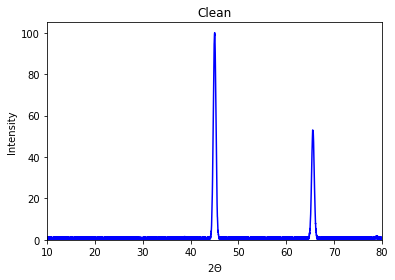

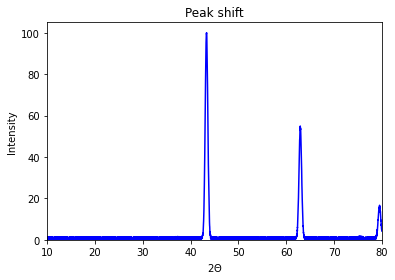

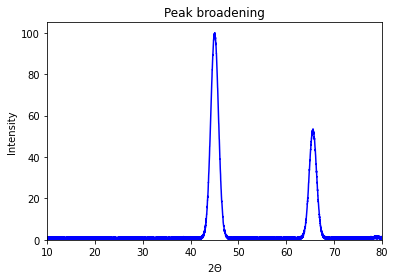

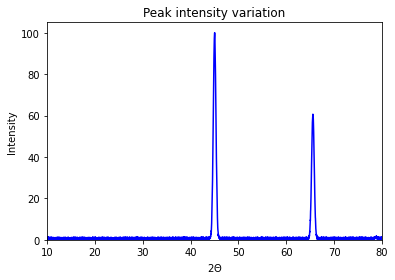

In [4]:
import matplotlib.pyplot as plt


# Simulate ideal spectra (no artifacts)
xrd_obj = spectrum_generation.SpectraGenerator(ref_dir, num_spectra=1, max_texture=0.0,
                                     min_domain_size=100, max_domain_size=100, max_strain=0.0)
xrd_specs = xrd_obj.augmented_spectra

# Clean pattern
clean_y = xrd_specs[0][0]

# Load augmented spectra
xrd = np.load('XRD.npy')

x = np.linspace(10, 80, 4501) # Two-theta

y1 = xrd[0][0] # Peak shift
y2 = xrd[0][10] # Peak broadening
y3 = xrd[0][20] # Peak intensity variation

# Plot spectra

def format_plot():
    plt.xlim(10, 80)
    plt.ylim(0, 105)
    plt.xlabel(r'2$\Theta$')
    plt.ylabel('Intensity')

plt.title('Clean')
plt.plot(x, clean_y, 'b-')
format_plot()
plt.show()

plt.title('Peak shift')
plt.plot(x, y1, 'b-')
format_plot()
plt.show()

plt.title('Peak broadening')
plt.plot(x, y2, 'b-')
format_plot()
plt.show()

plt.title('Peak intensity variation')
plt.plot(x, y3, 'b-')
format_plot()
plt.show()


### Step 4: Training the CNN

Using these simulated spectra, we can train our deep learning model as follows:

In [5]:
from autoXRD import cnn


# Load augmented spectra
xrd = np.load('XRD.npy')

# Train on 90% of spectra for 8 epochs
cnn.main(xrd, num_epochs=8, testing_fraction=0.1)

print('\nModel ready')

Epoch 1/8
4/4 [==============================] - 4s 721ms/step - loss: 0.8271 - binary_accuracy: 0.6922 - val_loss: 0.3228 - val_binary_accuracy: 0.8667
Epoch 2/8
4/4 [==============================] - 2s 514ms/step - loss: 0.4034 - binary_accuracy: 0.8256 - val_loss: 0.2099 - val_binary_accuracy: 0.9111
Epoch 3/8
4/4 [==============================] - 2s 511ms/step - loss: 0.2541 - binary_accuracy: 0.8922 - val_loss: 0.1886 - val_binary_accuracy: 0.9259
Epoch 4/8
4/4 [==============================] - 2s 511ms/step - loss: 0.2199 - binary_accuracy: 0.9211 - val_loss: 0.1882 - val_binary_accuracy: 0.9407
Epoch 5/8
4/4 [==============================] - 2s 508ms/step - loss: 0.1720 - binary_accuracy: 0.9365 - val_loss: 0.1828 - val_binary_accuracy: 0.9259
Epoch 6/8
4/4 [==============================] - 2s 512ms/step - loss: 0.1411 - binary_accuracy: 0.9532 - val_loss: 0.1866 - val_binary_accuracy: 0.9259
Epoch 7/8
4/4 [==============================] - 2s 509ms/step - loss: 0.1401 - bi


A trained Model.h5 object will now be available in the working directory. This model can be used to identify phases from spectra in the MnO-LiF composition space.

## Model application

We next demonstrate how the trained model can be applied to handle new spectra. For this purpose, an experimental spectrum measured from a mixture of LiF and MnO has been placed in the Spectra folder.

To classify this spectrum and visualize the results, run the following code. Note this process may take ~1 minute to complete.

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.

Filename: LiF+MnO.xy
Predicted phases: ['MnO_225', 'LiF_225']
Confidence: [78.0, 99.0]


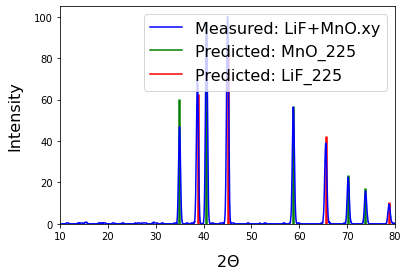

In [2]:
from autoXRD import spectrum_analysis, visualizer


# Folder containing test spectra
spec_dir = 'Spectra'

# Classify all files in spec_dir using references from ref_dir
spectrum_names, predicted_phases, confidences = spectrum_analysis.main(spec_dir, ref_dir, parallel=False)

for (spectrum_fname, phase_set, confidence) in zip(spectrum_names, predicted_phases, confidences):

    all_phases = phase_set.split(' + ')
    all_probs = [float(val[:-1]) for val in confidence]
    final_phases, final_confidence = [], []
    for (ph, cf) in zip(all_phases, all_probs):
        if cf >= 50.0: # Ignore phases with a low probability
            final_phases.append(ph)
            final_confidence.append(cf)
            
    print('Filename: %s' % spectrum_fname)
    print('Predicted phases: %s' % final_phases)
    print('Confidence: %s' % final_confidence)
    
    # Format predicted phases into a list of their CIF filenames
    predicted_phases = phase_set.split(' + ')
    predicted_phases = ['%s.cif' % phase for phase in predicted_phases]

    # Plot measured spectrum with line profiles of predicted phases
    visualizer.main(spec_dir, spectrum_fname, predicted_phases)


Hence, the predicted phases match our expectations based on experiment. The probabilities given for each phase provide a measure of confidence in the prediction.

Multi-phase classification is carried out using an iterative proess of phase identification and profile substraction. This process is illustrated below.

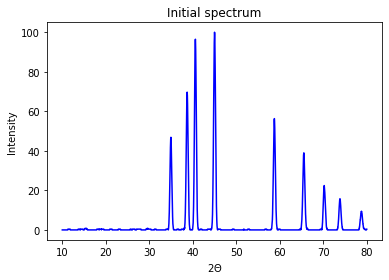

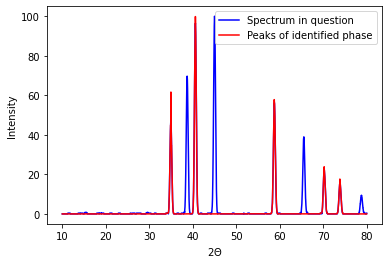

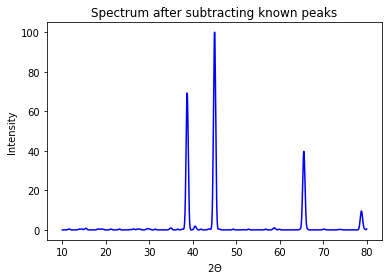

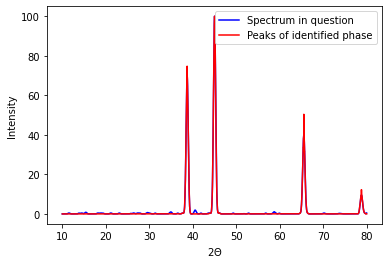

(['LiF+MnO.xy'], ['MnO_225 + LiF_225'], [['76.0%', '100.0%']])

In [3]:
import multiphase_steps # Modified spectrum_analysis for tutorial


multiphase_steps.main(spec_dir, ref_dir)



The experimental spectrum is shown in the top plot. Peaks from both LiF and MnO are present. 

The first phase to be identified is MnO. Accordingly, its peaks (red) are simulated and fit to the experimental spectrum (blue). This is shown by the second plot.

The peaks of the known phase (MnO) are then subtracted to produce a new spectrum shown in the third plot. This spectrum represents the mixture minus that phases that have already been identified. In this case, it closely resembles the peaks that are expected from a single-phase sample of LiF.

Next, LiF is identified from the modified spectrum. Its peaks (red) are fit to the modified spectrum (blue) as shown in the final plot. Once these peaks are subtracted from the spectrum, all remaining intensities are weak, suggesting that all phases have been identified. Therefore, the process is complete.